# IBM Data Science Capstone Project:
## Univeristies/College Affects on Toronto Neighboorhoods
---

Initial stages of the project.

In [1]:
#!pip install bs4
#!pip install requests

from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (8,5)

In [2]:
# ottawa url
#url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_K"
# Toronto url
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [3]:
#!pip install html5lib

data  = requests.get(url).text
soup = BeautifulSoup(data,"html.parser")

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
geo_data = pd.read_csv("Geospatial_Coordinates.csv")
geo_data.rename(columns={"Postal Code": "PostalCode"}, inplace=True)

toronto_borough = df.merge(geo_data, on=["PostalCode"])

## Univerity Data

In [6]:
uni_data = pd.read_csv("Universities.csv")
uni_data
#toronto_borough = df.merge(uni_data, on=["PostalCode"])
unit_postal = uni_data.set_index("PostalCode")


## Covid Data

In [7]:
covid_data = pd.read_csv("COVID19_cases.csv")
covid_confirm = covid_data.loc[covid_data['Source of Infection'] == "Community"]

total_cummunity_cases = covid_confirm.groupby('FSA').count()['Outcome'].sum()

covid_postal = covid_confirm.groupby('FSA').count()[['Outcome']]/total_cummunity_cases
#toronto_borough = df.merge(uni_data, on=["PostalCode"]
covid = covid_postal.reset_index()

In [8]:
uni = []
uni_population = []
uni_one_hot = []
normalized_covid = []
for value in toronto_borough['PostalCode']:
    if uni_data['PostalCode'].str.contains(value).any():
        uni.append(unit_postal.loc[value, 'universities'])
        uni_population.append(unit_postal.loc[value, 'num_students'])
        uni_one_hot.append(1)
    else:
        uni.append("N/A")
        uni_population.append("N/A")
        uni_one_hot.append(0)
    
    if covid['FSA'].str.contains(value).any():
        normalized_covid.append(covid_postal.loc[value,"Outcome"])
    else:
        normalized_covid.append("N/A")

toronto_borough['Universities'] = uni
toronto_borough['Uni_score'] = uni_one_hot
toronto_borough['Uni_population'] = uni_population
toronto_borough['Covid_cases'] = normalized_covid

#toronto_borough = toronto_borough[toronto_borough['Borough'].str.contains('Toronto', na=False)].reset_index(drop=True)

In [9]:
toronto_borough

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Universities,Uni_score,Uni_population,Covid_cases
0,M3A,North York,Parkwoods,43.753259,-79.329656,N/A,0,N/A,0.011768
1,M4A,North York,Victoria Village,43.725882,-79.315572,N/A,0,N/A,0.005728
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,N/A,0,N/A,0.013383
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,N/A,0,N/A,0.01182
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,N/A,0,N/A,N/A
...,...,...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,N/A,0,N/A,0.001059
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,N/A,0,N/A,0.007047
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558,N/A,0,N/A,N/A
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,N/A,0,N/A,0.005311


In [233]:
toronto_with_uni = toronto_borough.loc[toronto_borough['Uni_score'] == 1]
toronto_no_uni = toronto_borough.loc[toronto_borough['Uni_score'] == 0]
toronto_with_uni
print(toronto_with_uni[["PostalCode","Borough","Latitude","Longitude","Universities","Uni_population","Covid_cases"]].to_latex(index=False))

\begin{tabular}{llrrlll}
\toprule
PostalCode &             Borough &  Latitude &  Longitude & Universities & Uni\_population & Covid\_cases \\
\midrule
       M5B &    Downtown Toronto & 43.657162 & -79.378937 &      Ryerson &          39471 &    0.003853 \\
       M1C &         Scarborough & 43.784535 & -79.160497 &         UofT &          12980 &    0.011873 \\
       M1G &         Scarborough & 43.770992 & -79.216917 &   Contennial &          35000 &    0.017357 \\
       M2J &          North York & 43.778517 & -79.346556 &       Seneca &          97500 &    0.020655 \\
       M3J &          North York & 43.767980 & -79.487262 &         York &          49905 &    0.019874 \\
       M2M &          North York & 43.789053 & -79.408493 &      Tysdale &           1361 &    0.011074 \\
       M5R &     Central Toronto & 43.672710 & -79.405678 & George Brown &          32117 &    0.003836 \\
       M5S &    Downtown Toronto & 43.662696 & -79.400049 &         UofT &         93,081 &    0.00

In [11]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

colors_array = cm.rainbow(np.linspace(0, 1, 2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, label, score, cases in zip(toronto_borough['Latitude'], toronto_borough['Longitude'], 
                                  toronto_borough['Universities'], toronto_borough['Uni_score'],
                                  toronto_borough['Covid_cases']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=500*cases,
        popup=label,
        color=rainbow[score],        
        fill=True,
        fill_color=rainbow[score],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Foursqaure

In [13]:
CODE = 'TOE5BRLEPMPXYFTDGT2PXETJNSP11DCCOWUPK0YH5OH4AOAD#_=_'
CLIENT_ID = 'SMKLR0VGYBHHDRS3TAM1TIVWP0LVHRUHKWH4HEBL0MVV0OET' # your Foursquare ID
CLIENT_SECRET = 'KMAIVPNSSJONCUE21HWO30GYMS45RUXKTNKVCCF2WULUNAOX' # your Foursquare Secret
ACCESS_TOKEN = '0TDX3DRBBF1DS052LGFKZIDKWOWOZEWFVULT0LI4TSUJZDMP' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SMKLR0VGYBHHDRS3TAM1TIVWP0LVHRUHKWH4HEBL0MVV0OET
CLIENT_SECRET:KMAIVPNSSJONCUE21HWO30GYMS45RUXKTNKVCCF2WULUNAOX


In [14]:
search_query_cafe = 'cafe'
search_query_coffee = 'coffee'

In [48]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [41]:
def getNearbyVenues(names, borough, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, bor, lat, lng in zip(names, borough, latitudes, longitudes):
            
        url_coffee = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            ACCESS_TOKEN, 
            VERSION, 
            search_query_coffee, 
            radius, 
            LIMIT)
            
        # make the GET request
        results_coffee = requests.get(url_coffee).json()['response']['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            bor,
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['location']['distance'],  
            get_category_type(v)) for v in results_coffee])
    
        if not venues_list:
            venues_list.append([
            name, 
            lat, 
            lng, 
            bor,
            "name", 
            "name", 
            "name",  
            "name",  
            "name"])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Borough', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue distance',
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
uni_cafes = getNearbyVenues(toronto_with_uni["PostalCode"], toronto_with_uni["Borough"], toronto_with_uni["Latitude"],
                            toronto_with_uni["Longitude"], radius=500)
public_cafes = getNearbyVenues(toronto_no_uni["PostalCode"],toronto_no_uni["Borough"], toronto_no_uni["Latitude"],
                               toronto_no_uni["Longitude"], radius=500)

In [56]:
print(uni_cafes.shape)
uni_cafes

(65, 9)


,PostalCode,Neighborhood Latitude,Neighborhood Longitude,Borough,Venue,Venue Latitude,Venue Longitude,Venue distance,Venue Category
0,M5B,43.657162,-79.378937,Downtown Toronto,Balzac's Coffee,43.657854,-79.379200,79,Coffee Shop
1,M5B,43.657162,-79.378937,Downtown Toronto,Timothy's World Coffee,43.656700,-79.379941,95,Coffee Shop
2,M5B,43.657162,-79.378937,Downtown Toronto,Timothy's World Coffee,43.660714,-79.385491,659,Coffee Shop
3,M5B,43.657162,-79.378937,Downtown Toronto,Timothy's World Coffee,43.653436,-79.382314,495,Coffee Shop
4,M5B,43.657162,-79.378937,Downtown Toronto,Timothy's World Coffee,43.660467,-79.384654,589,Coffee Shop
...,...,...,...,...,...,...,...,...,...
60,M5T,43.653206,-79.400049,Downtown Toronto,Hopper Coffee,43.657479,-79.402691,521,Coffee Shop
61,M5T,43.653206,-79.400049,Downtown Toronto,Second Cup Coffee Co.,43.653386,-79.405942,475,Café
62,M5T,43.653206,-79.400049,Downtown Toronto,The Moonbean Cafe,43.654147,-79.400182,105,Café
63,M5T,43.653206,-79.400049,Downtown Toronto,Dark Horse Espresso Bar,43.650564,-79.397018,382,Coffee Shop


In [55]:
#public_cafes.groupby('PostalCode').count()
uni_cafes.groupby('PostalCode').count()

,Neighborhood Latitude,Neighborhood Longitude,Borough,Venue,Venue Latitude,Venue Longitude,Venue distance,Venue Category
PostalCode,,,,,,,,
M2J,4,4,4,4,4,4,4,4
M5B,33,33,33,33,33,33,33,33
M5R,4,4,4,4,4,4,4,3
M5S,9,9,9,9,9,9,9,8
M5T,15,15,15,15,15,15,15,15


In [45]:
print('There are {} uniques categories.'.format(len(uni_cafes['Venue'].unique())))
uni_cafes['Venue'].value_counts().head()
#public_cafes['Venue'].value_counts().head()

There are 48 uniques categories.


Second Cup Coffee Co.     7
Starbucks                 6
Timothy's World Coffee    4
Jimmy's Coffee            2
Reunion Island Coffee     2
Name: Venue, dtype: int64

In [46]:
# one hot encoding
uni_onehot = pd.get_dummies(uni_cafes[['Venue']], prefix="", prefix_sep="")
public_onehot = pd.get_dummies(public_cafes[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uni_onehot['PostalCode'] = uni_cafes['PostalCode'] 
public_onehot['PostalCode'] = public_cafes['PostalCode'] 

# move neighborhood column to the first column
fixed_columns_uni = [uni_onehot.columns[-1]] + list(uni_onehot.columns[:-1])
uni_onehot = uni_onehot[fixed_columns_uni]
fixed_columns_public = [public_onehot.columns[-1]] + list(public_onehot.columns[:-1])
public_onehot = public_onehot[fixed_columns_public]

In [50]:
uni_grouped = uni_onehot.groupby('PostalCode').mean().reset_index()
public_grouped = public_onehot.groupby('PostalCode').mean().reset_index()
public_grouped.head()


,PostalCode,135 Ossington,800 Coffee Bar,A Coffee Cup,AMPM Coffee,Arena Coffee Bar,Aroma Espresso Bar,At Origin Coffee,Balzac's Coffee,Balzac’s Coffee,...,Urbana Coffee Co.,Versus Coffee,Well And Better Coffee,White Squirrel,Youngplace Coffee Pub,Zavida Coffee Roasters,google coffee bar,i deal coffee,milano coffee,unicorn coffee
0,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M2N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M3C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [63]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
uni_cafe_sorted = pd.DataFrame(columns=columns)
uni_cafe_sorted['PostalCode'] = uni_grouped['PostalCode']

public_cafe_sorted = pd.DataFrame(columns=columns)
public_cafe_sorted['PostalCode'] = public_grouped['PostalCode']

for ind in np.arange(uni_grouped.shape[0]):
    uni_cafe_sorted.iloc[ind, 1:] = return_most_common_venues(uni_grouped.iloc[ind, :], num_top_venues)
for ind in np.arange(public_grouped.shape[0]):
    public_cafe_sorted.iloc[ind, 1:] = return_most_common_venues(public_grouped.iloc[ind, :], num_top_venues)

public_cafe_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M1H,Coffee Culture Cafe & Eatery,135 Ossington,Reunion Island Coffee,Piedmont Coffee Bar
1,M1R,Sam's Coffee Truck,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar
2,M1W,Coffee Time,Coffee Here,Sam's Coffee Truck,Sam James Coffee Bar Oz
3,M2N,Second Cup Coffee Co. featuring Pinkberry Froz...,Little Italy Coffee Shop,Second Cup Coffee Co.,Coffee Plus
4,M3C,Pauls coffee shop,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar


## Clustering

In [62]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

public_grouped_clustering = public_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(public_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

/anaconda3/envs/DataScience/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


array([4, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 0, 1, 1],
      dtype=int32)

In [153]:
# add clustering labels
#public_cafe_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#public_merged = toronto_no_uni

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
#public_merged = public_merged.join(public_cafe_sorted.set_index('PostalCode'), on='PostalCode')

public_merged.head() # check the last columns!
public_finale = public_merged.dropna()


In [154]:
public_finale.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Universities,Uni_score,Uni_population,Covid_cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,N/A,0,N/A,0.013383,1.0,Keefaa Coffee,Cup of coffee,Cuppa Coffee Studios,Arena Coffee Bar
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,N/A,0,N/A,N/A,1.0,Second Cup Coffee Co.,Second Cup Coffee Co. featuring Pinkberry Froz...,Timothy's World Coffee,NEO COFFEE BAR
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,N/A,0,N/A,0.004912,1.0,Nostalgia Coffee Co.,135 Ossington,Reunion Island Coffee,Piedmont Coffee Bar
10,M6B,North York,Glencairn,43.709577,-79.445073,N/A,0,N/A,0.01366,1.0,Sweet House Coffee,135 Ossington,RailRoad Coffee Co.,Pavillion Coffee
13,M3C,North York,Don Mills South,43.725900,-79.340923,N/A,0,N/A,0.017288,1.0,Pauls coffee shop,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar


In [224]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, cases in zip(public_finale['Latitude'], public_finale['Longitude'],
                                         public_finale['PostalCode'], public_finale['Cluster Labels'],
                                         public_finale['Covid_cases']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=500*cases,
        #radius = 5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

AttributeError: 'dict' object has no attribute 'rgb2hex'

In [156]:
public_finale.loc[public_finale['Cluster Labels'] == 0, public_finale.columns[[1] + list(range(5, public_finale.shape[1]))]]



,Borough,Universities,Uni_score,Uni_population,Covid_cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
14,East York,N/A,0,N/A,0.013296,0.0,Coffee Time,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar
31,West Toronto,N/A,0,N/A,0.014667,0.0,Coffee Time,Balzac’s Coffee,The Peoples Coffee Time,Mast Coffee
47,East Toronto,N/A,0,N/A,0.004947,0.0,unicorn coffee,Simple Coffee,Coffee time,Coffee Time
88,Etobicoke,N/A,0,N/A,0.012098,0.0,Coffee Time,Big Guy's Little Coffee Shop,Pauls coffee shop,Piedmont Coffee Bar
90,Scarborough,N/A,0,N/A,0.015986,0.0,Coffee Time,Coffee Here,Sam's Coffee Truck,Sam James Coffee Bar Oz


In [157]:
public_finale.loc[public_finale['Cluster Labels'] == 4, public_finale.columns[[1] + list(range(5, public_finale.shape[1]))]]


,Borough,Universities,Uni_score,Uni_population,Covid_cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
26,Scarborough,N/A,0,N/A,0.011317,4.0,Coffee Culture Cafe & Eatery,135 Ossington,Reunion Island Coffee,Piedmont Coffee Bar


# Distance to Universities

In [158]:
def distance_to_uni(lat, lng, uni_df):
    dist = []
    for index, row in uni_df.iterrows():
        euclid = np.sqrt((row["Latitude"]-lat)**2 + (row["Longitude"]-lng)**2)
        dist.append([euclid, row["Universities"],row["Uni_population"] ])

    return min(dist)

In [129]:
distance_to_uni(2,2,toronto_with_uni)

[91.2851229009538, 'UofT', '12980']

In [159]:
public_finale["dist_to_uni"] = public_finale.apply(lambda x: distance_to_uni(x["Latitude"],x["Longitude"],toronto_with_uni)[0], axis=1)
public_finale["uni_population"] = public_finale.apply(lambda x: distance_to_uni(x["Latitude"],x["Longitude"],toronto_with_uni)[2], axis=1)

/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [226]:
#!pip install seaborn
#import seaborn as sns

#sns.lmplot('Covid_cases', 'Covid_cases', data=public_finale, fit_reg=False)
#plt.show()
#public_finale["Covid_cases"].replace(to_replace={"0.1": "0.001"}, inplace=True)
#public_finale["uni_population"].replace(to_replace={"93,081": "93000"}, inplace=True)
colors = {'0.0':'red', '1.0':'green', '2.0':'blue', '3.0':'yellow', '4.0':'orange', '5.0':'gray'}


rng = np.random.RandomState(0)
x = pd.to_numeric(public_finale['Covid_cases'])
y = pd.to_numeric(public_finale['dist_to_uni'])
s_test = pd.to_numeric(public_finale['uni_population'])
c = public_finale['Cluster Labels']
#colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}

#plt.scatter(x, y, s=100*df['population'], alpha=0.3,
#            c= df['continent'].map(colors),
#            cmap='viridis')
#plt.colorbar();  

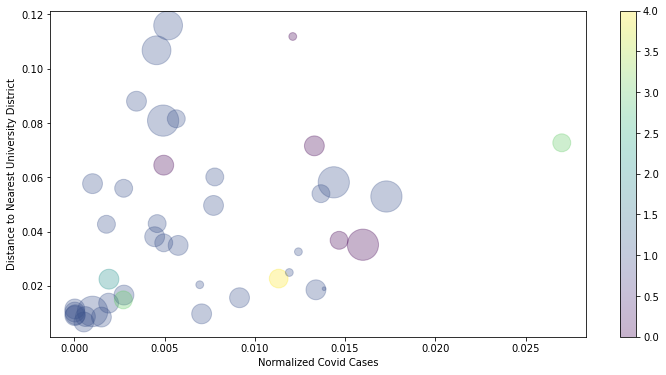

In [227]:
#colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}

#x.dtypes
colors = {'0.0':'red', '1.0':'green', '2.0':'blue', '3.0':'yellow', '4.0':'orange', '5.0':'gray'}
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(x, y, s=.01*s_test, alpha=0.3,
            c= public_finale['Cluster Labels'],
            cmap='viridis')
plt.xlabel("Normalized Covid Cases")
plt.ylabel("Distance to Nearest University District")
plt.colorbar(); 